#This notebook is for analyzing the multivariate time series and making predictions upon it

In [1]:
!pip install statsmodels --upgrade

     |████████████████████████████████| 9.8 MB 5.0 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [4]:
filepath = 'https://raw.githubusercontent.com/selva86/datasets/master/Raotbl6.csv'
varData = pd.read_csv(filepath, parse_dates=['date'], index_col='date')
print(varData.shape)  # (123, 8)
varData.tail()

(123, 8)


,rgnp,pgnp,ulc,gdfco,gdf,gdfim,gdfcf,gdfce
date,,,,,,,,
1988-07-01,4042.7,3971.9,179.6,131.5,124.9,106.2,123.5,92.8
1988-10-01,4069.4,3995.8,181.3,133.3,126.2,107.3,124.9,92.9
1989-01-01,4106.8,4019.9,184.1,134.8,127.7,109.5,126.6,94.0
1989-04-01,4132.5,4044.1,186.1,134.8,129.3,111.1,129.0,100.6
1989-07-01,4162.9,4068.4,187.4,137.2,130.2,109.8,129.9,98.2


#The dataset has following 8 quaterly time series

1. rgnp  : Real GNP.
2. pgnp  : Potential real GNP.
3. ulc   : Unit labor cost.
4. gdfco : Fixed weight deflator for personal consumption expenditure excluding food and energy.
5. gdf   : Fixed weight GNP deflator.
6. gdfim : Fixed weight import deflator.
7. gdfcf : Fixed weight deflator for food in personal consumption expenditure.
8. gdfce : Fixed weight deflator for energy in personal consumption expenditure.

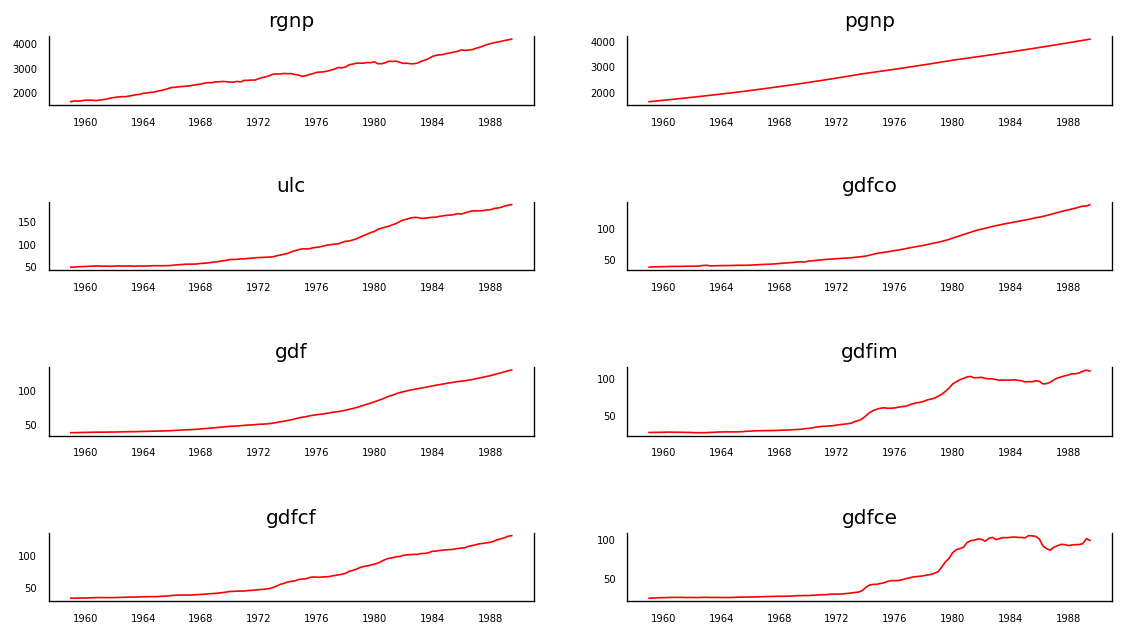

In [5]:
def visualuze_multivariate_time_series(data,rows:int=4,cols:int=2):
  fig, axes = plt.subplots(nrows=rows, ncols=cols, dpi=120, figsize=(10,6))
  # i will simply give the column count/index
  for i, ax in enumerate(axes.flatten()):
    df = data[data.columns[i]]
    ax.plot(df, color='red', linewidth=1)
    fig.tight_layout(pad=3.0)#this is for providing proper spacing between the plots
    # Decorations
    ax.set_title(data.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)
visualuze_multivariate_time_series(varData)

#Testing Causation using Granger’s Causality Test

The basis behind Vector AutoRegression is that each of the time series in the system influences each other. That is, you can predict the series with past values of itself along with other series in the system.

Using Granger’s Causality Test, it’s possible to test this relationship before even building the model.

So what does Granger’s Causality really test?

Granger’s causality tests the null hypothesis that the coefficients of past values in the regression equation is zero.

In simpler terms, the past values of time series (X) do not cause the other series (Y). So, if the p-value obtained from the test is lesser than the significance level of 0.05, then, you can safely reject the null hypothesis.



In [16]:
def grangers_causation_matrix(data, variables,maxlag:int=12, test:str='ssr_chi2test', verbose:bool=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    from statsmodels.tsa.stattools import grangercausalitytests
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df


#how to read this table?
'''
If a given p-value is < significance level (0.05), 
then, the corresponding X time series (column) causes/effects the Y time series (row).
'''


grangers_causation_matrix(varData, variables = varData.columns)

,rgnp_x,pgnp_x,ulc_x,gdfco_x,gdf_x,gdfim_x,gdfcf_x,gdfce_x
rgnp_y,1.0000,0.0003,0.0001,0.0212,0.0014,0.0620,0.0001,0.0071
pgnp_y,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
ulc_y,0.0000,0.0000,1.0000,0.0002,0.0000,0.0000,0.0000,0.0041
gdfco_y,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000
gdf_y,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000
gdfim_y,0.0011,0.0067,0.0014,0.0083,0.0011,1.0000,0.0004,0.0000
gdfcf_y,0.0000,0.0000,0.0008,0.0008,0.0000,0.0038,1.0000,0.0009
gdfce_y,0.0025,0.0485,0.0000,0.0002,0.0000,0.0000,0.0000,1.0000


#Cointegration test✈

**Cointegration test helps to establish the presence of a statistically significant connection between two or more time series.**

But, what does Cointegration mean?

To understand that, you first need to know what is ‘order of integration’ (d).

**Order of integration(d) is nothing but the number of differencing required to make a non-stationary time series stationary.**

**Now, when you have two or more time series, and there exists a linear combination of them that has an order of integration (d) less than that of the individual series, then the collection of series is said to be cointegrated.**

Ok?

When two or more time series are cointegrated, it means they have a long run, statistically significant relationship.

This is the basic premise on which Vector Autoregression(VAR) models is based on. So, it’s fairly common to implement the cointegration test before starting to build VAR models.

In [14]:
def cointegration_test(df, alpha=0.05):
  from statsmodels.tsa.vector_ar.vecm import coint_johansen 
  """Perform Johanson's Cointegration Test and Report Summary"""
  out = coint_johansen(df,-1,5)
  d = {'0.90':0, '0.95':1, '0.99':2}
  traces = out.lr1
  cvts = out.cvt[:, d[str(1-alpha)]]
  def adjust(val, length= 6): return str(val).ljust(length)
  # Summary
  print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
  for col, trace, cvt in zip(df.columns, traces, cvts):
    print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(varData)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
rgnp   ::  248.0     > 143.6691  =>   True
pgnp   ::  183.12    > 111.7797  =>   True
ulc    ::  130.01    > 83.9383   =>   True
gdfco  ::  85.28     > 60.0627   =>   True
gdf    ::  55.05     > 40.1749   =>   True
gdfim  ::  31.59     > 24.2761   =>   True
gdfcf  ::  14.06     > 12.3212   =>   True
gdfce  ::  0.45      > 4.1296    =>   False


In [17]:
#splitting the dataset into train and test set
nobs = 4 #this is the numbe of elements that will be contained in the test set
df_train, df_test = varData[0:-nobs], varData[-nobs:]

# Check size
print(df_train.shape)  # (119, 8)
print(df_test.shape)  # (4, 8)

(119, 8)
(4, 8)


In [18]:
#checking for stationarity and making the time series stationary
#implementing ADFuller test with significance/threshold value of 0.5
def adfuller_test(series, signif=0.05, name='', verbose=False):
  from statsmodels.tsa.stattools import adfuller
  """Perform ADFuller to test for Stationarity of given series and print report"""
  r = adfuller(series, autolag='AIC')
  output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
  p_value = output['pvalue'] 
  def adjust(val, length= 6): return str(val).ljust(length)
  # Print Summary
  print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
  print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
  print(f' Significance Level    = {signif}')
  print(f' Test Statistic        = {output["test_statistic"]}')
  print(f' No. Lags Chosen       = {output["n_lags"]}')
  for key,val in r[4].items():
    print(f' Critical value {adjust(key)} = {round(val, 3)}')
  
  if p_value <= signif:
    print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
    print(f" => Series is Stationary.")
  else:
    print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
    print(f" => Series is Non-Stationary.")    

In [19]:
#implementing ADFuller test on each column
for name, column in df_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "rgnp" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = 0.5428
 No. Lags Chosen       = 2
 Critical value 1%     = -3.488
 Critical value 5%     = -2.887
 Critical value 10%    = -2.58
 => P-Value = 0.9861. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "pgnp" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = 1.1556
 No. Lags Chosen       = 1
 Critical value 1%     = -3.488
 Critical value 5%     = -2.887
 Critical value 10%    = -2.58
 => P-Value = 0.9957. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "ulc" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. N

In [20]:
#since none of the time series is stationaty therefore differencing all of them
df_differenced = df_train.diff().dropna()
#AD Fuller test on each of the tim series
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "rgnp" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.3448
 No. Lags Chosen       = 1
 Critical value 1%     = -3.488
 Critical value 5%     = -2.887
 Critical value 10%    = -2.58
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "pgnp" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.8282
 No. Lags Chosen       = 0
 Critical value 1%     = -3.488
 Critical value 5%     = -2.887
 Critical value 10%    = -2.58
 => P-Value = 0.3666. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "ulc" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Signifi

In [21]:
#since some of the time series are still non stationary therfore again differencing them
df_differenced = df_differenced.diff().dropna()
# ADF Test on each column of 2nd Differences Dataframe
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "rgnp" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -9.0123
 No. Lags Chosen       = 2
 Critical value 1%     = -3.489
 Critical value 5%     = -2.887
 Critical value 10%    = -2.58
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "pgnp" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -10.9813
 No. Lags Chosen       = 0
 Critical value 1%     = -3.488
 Critical value 5%     = -2.887
 Critical value 10%    = -2.58
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "ulc" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 T

In [22]:
#All the time series are stationary now we can proceed
#How to select the right order P of the var model
def check_lag(data):
  from statsmodels.tsa.api import VAR
  model = VAR(data)
  for i in [1,2,3,4,5,6,7,8,9]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

# we select the model and one of the criteria is BIC the value in inversely proportional to the performance of the model
check_lag(df_differenced)

Lag Order = 1
AIC :  -1.3679402315450664
BIC :  0.3411847146588838
FPE :  0.2552682517347198
HQIC:  -0.6741331335699554 

Lag Order = 2
AIC :  -1.621237394447823
BIC :  1.6249432095295857
FPE :  0.2011349437137141
HQIC:  -0.3036288826795914 

Lag Order = 3
AIC :  -1.7658008387012782
BIC :  3.034547316376784
FPE :  0.18125103746164378
HQIC:  0.18239143783963385 

Lag Order = 4
AIC :  -2.000735164470316
BIC :  4.371215137654089
FPE :  0.15556966521481125
HQIC:  0.5849359332771087 

Lag Order = 5
AIC :  -1.9619535608363972
BIC :  5.999364562242094
FPE :  0.18692794389114853
HQIC:  1.2682063311783311 

Lag Order = 6
AIC :  -2.3303386524829035
BIC :  7.238452689088582
FPE :  0.16380374017443694
HQIC:  1.551437166954809 

Lag Order = 7
AIC :  -2.592331352347129
BIC :  8.602387254937796
FPE :  0.1823868583715414
HQIC:  1.9483069621146551 

Lag Order = 8
AIC :  -3.317261976458205
BIC :  9.52219581032303
FPE :  0.15573163248209088
HQIC:  1.8896071386220985 

Lag Order = 9
AIC :  -4.804763125958

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  % freq, ValueWarning)


In [25]:
#or we can use this function
def check_lag_auto(data,maxlags:int=12):
  from statsmodels.tsa.api import VAR
  model = VAR(df_differenced)
  x = model.select_order(maxlags=12)
  display(x.summary())

check_lag_auto(df_differenced)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  % freq, ValueWarning)


,AIC,BIC,FPE,HQIC
0,-0.07898,0.1232,0.9241,0.002961
1,-0.5721,1.248,0.5662,0.1653
2,-0.8256,2.612,0.4482,0.5674
3,-1.007,4.048,0.3937,1.042
4,-1.255,5.418,0.3399,1.449
5,-1.230,7.060,0.4147,2.129
6,-1.739,8.169,0.3286,2.276
7,-2.142,9.384,0.3340,2.528
8,-2.964,10.18,0.2744,2.362
9,-4.562,10.20,0.1413,1.420


In [26]:
#selecting the lag 4 since it is giving the best results
def train_model(data,lag:int):
  from statsmodels.tsa.api import VAR
  model = VAR(data)
  model_fitted = model.fit(lag)
  return model_fitted

In [27]:
var_model = train_model(df_differenced,4)
var_model.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  % freq, ValueWarning)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 08, Dec, 2021
Time:                     19:28:37
--------------------------------------------------------------------
No. of Equations:         8.00000    BIC:                    4.37122
Nobs:                     113.000    HQIC:                  0.584936
Log likelihood:          -905.679    FPE:                   0.155570
AIC:                     -2.00074    Det(Omega_mle):       0.0200322
--------------------------------------------------------------------
Results for equation rgnp
              coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------
const            2.430021         2.677505            0.908           0.364
L1.rgnp         -0.750066         0.159023           -4.717           0.000
L1.pgnp         -0.095621         4.938865           -0.019           0.985
L1.ul

#Check for Serial Correlation of Residuals (Errors) using Durbin Watson Statistic

# Serial correlation of residuals is used to check if there is any leftover pattern in the residuals (errors).

What does this mean to us?

If there is any correlation left in the residuals, then, there is some pattern in the time series that is still left to be explained by the model. In that case, the typical course of action is to either increase the order of the model or induce more predictors into the system or look for a different algorithm to model the time series.

So, checking for serial correlation is to ensure that the model is sufficiently able to explain the variances and patterns in the time series.

Alright, coming back to topic.

In [28]:
'''
The value of this statistic can vary between 0 and 4.
 The closer it is to the value 2, then there is no 
 significant serial correlation. 
 The closer to 0, there is a positive serial correlation,
  and the closer it is to 4 implies negative serial correlation.
'''
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(var_model.resid)

for col, val in zip(varData.columns, out):
    print(col, ':', round(val, 2))

rgnp : 2.09
pgnp : 2.02
ulc : 2.17
gdfco : 2.05
gdf : 2.25
gdfim : 1.99
gdfcf : 2.2
gdfce : 2.17


In [29]:
#forecasting using varModel
# Get the lag order
lag_order = var_model.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input = df_differenced.values[-lag_order:]
forecast_input

4


array([[ 13.5,   0.1,   1.4,   0.1,   0.1,  -0.1,   0.4,  -2. ],
       [-23.6,   0.2,  -2. ,  -0.5,  -0.1,  -0.2,  -0.3,  -1.2],
       [ -3.3,   0.1,   3.1,   0.5,   0.3,   0.4,   0.9,   2.2],
       [ -3.9,   0.2,  -2.1,  -0.4,   0.2,  -1.5,   0.9,  -0.3]])

In [30]:
#forecast
fc = var_model.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=varData.index[-nobs:], columns=varData.columns + '_2d')
df_forecast

,rgnp_2d,pgnp_2d,ulc_2d,gdfco_2d,gdf_2d,gdfim_2d,gdfcf_2d,gdfce_2d
date,,,,,,,,
1988-10-01,48.322456,1.250774,0.595993,0.265657,-0.104146,0.304119,-0.917227,-0.113061
1989-01-01,-34.962286,-0.387966,-0.329877,-0.042217,0.164633,1.357223,0.618163,3.029975
1989-04-01,20.392680,0.291298,0.390812,-0.134488,-0.486073,-0.149551,-1.238234,-2.345223
1989-07-01,-37.416599,-0.280943,0.367912,0.102797,0.333371,-0.502103,0.469468,0.517424


In [31]:
#invert the transformation to get the real data
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [32]:
df_results = invert_transformation(df_train, df_forecast, second_diff=True)        
df_results.loc[:, ['rgnp_forecast', 'pgnp_forecast', 'ulc_forecast', 'gdfco_forecast',
                   'gdf_forecast', 'gdfim_forecast', 'gdfcf_forecast', 'gdfce_forecast']]

,rgnp_forecast,pgnp_forecast,ulc_forecast,gdfco_forecast,gdf_forecast,gdfim_forecast,gdfcf_forecast,gdfce_forecast
date,,,,,,,,
1988-10-01,4123.022456,3996.950774,181.095993,132.965657,126.395854,106.604119,125.082773,93.186939
1989-01-01,4168.382626,4021.613582,182.262108,134.389097,128.056341,108.365461,127.283708,96.603854
1989-04-01,4234.135476,4046.567687,183.819036,135.678050,129.230756,109.977252,128.246409,97.675545
1989-07-01,4262.471728,4071.240850,185.743875,137.069799,130.738542,111.086940,129.678579,99.264661


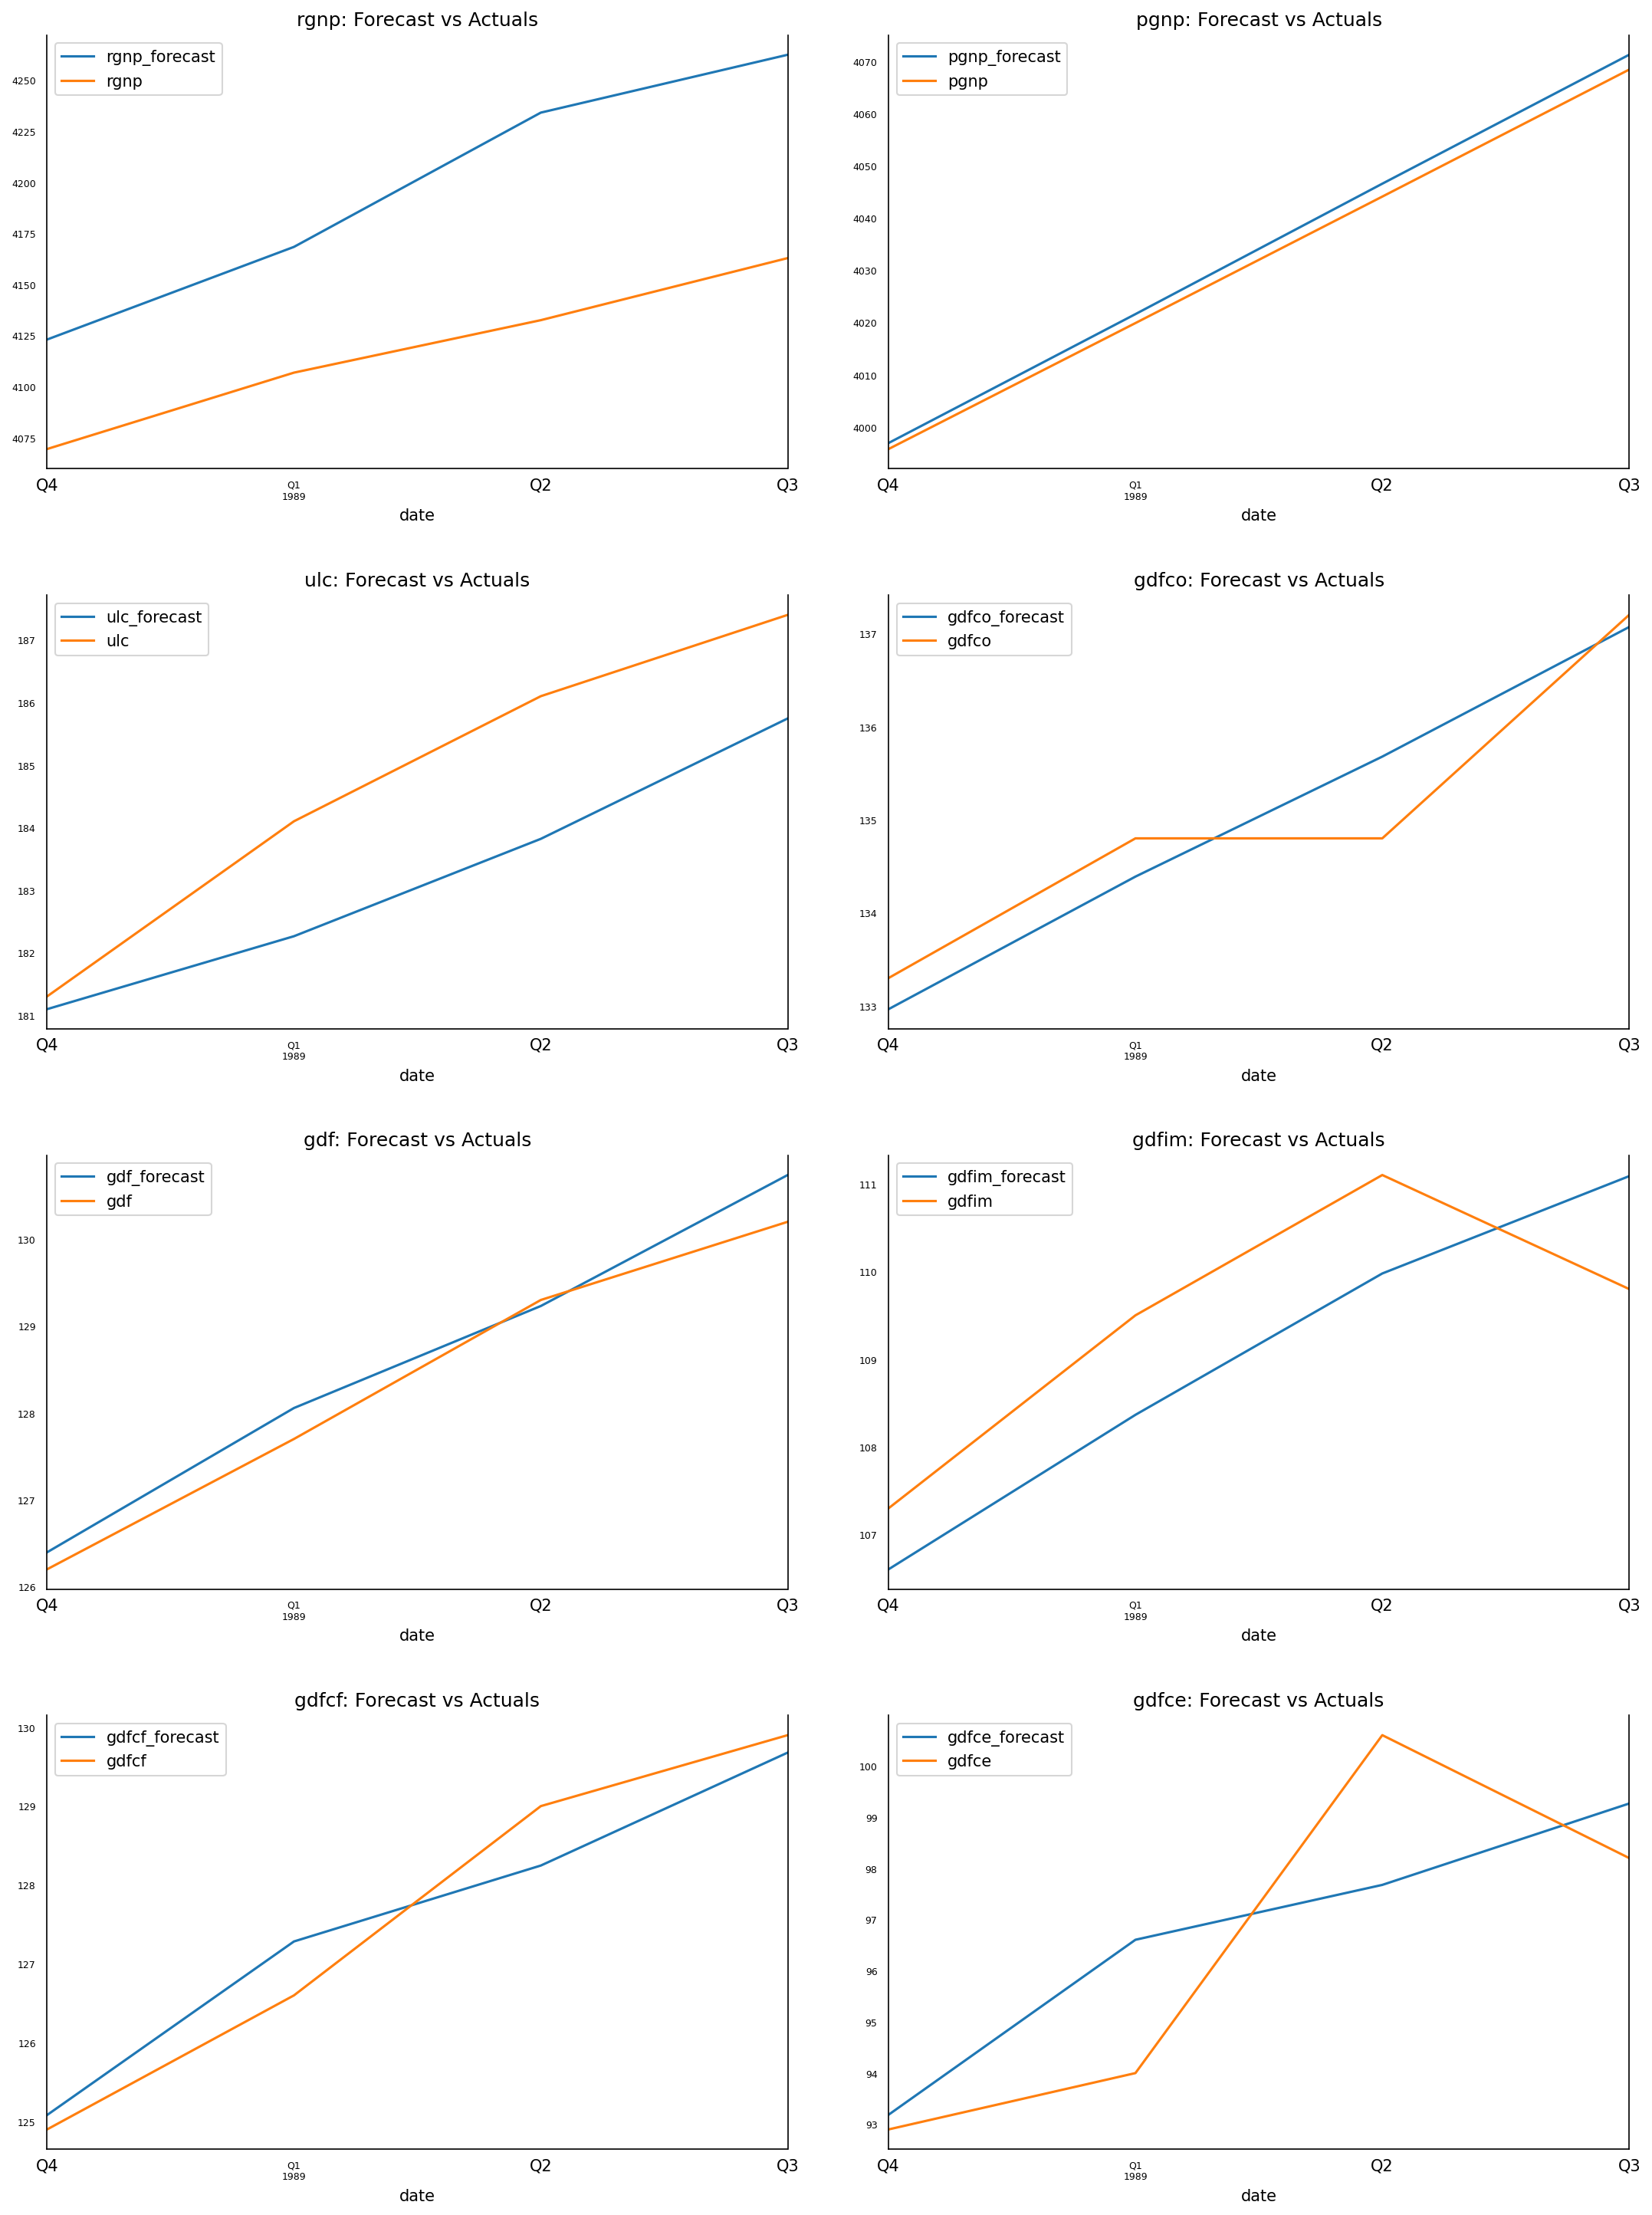

In [33]:
#Plotting forecast vs actual data
fig, axes = plt.subplots(nrows=int(len(varData.columns)/2), ncols=2, dpi=150, figsize=(15,20))
for i, (col,ax) in enumerate(zip(varData.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test[col][-nobs:].plot(legend=True, ax=ax);
    fig.tight_layout(pad=3.0)
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

In [34]:
#Evaluating the model 
def forecast_accuracy(forecast, actual):
  from statsmodels.tsa.stattools import acf
  mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
  me = np.mean(forecast - actual)             # ME
  mae = np.mean(np.abs(forecast - actual))    # MAE
  mpe = np.mean((forecast - actual)/actual)   # MPE
  rmse = np.mean((forecast - actual)**2)**.5  # RMSE
  corr = np.corrcoef(forecast, actual)[0,1]   # corr
  mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
  maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
  minmax = 1 - np.mean(mins/maxs)             # minmax
  return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})
  
#or you can loop through all the columns in the dataset and calculate for them
print('Forecast Accuracy of: rgnp')
accuracy_prod = forecast_accuracy(df_results['rgnp_forecast'].values, df_test['rgnp'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))
print('\nForecast Accuracy of: pgnp')
accuracy_prod = forecast_accuracy(df_results['pgnp_forecast'].values, df_test['pgnp'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

print('\nForecast Accuracy of: ulc')
accuracy_prod = forecast_accuracy(df_results['ulc_forecast'].values, df_test['ulc'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

print('\nForecast Accuracy of: gdfco')
accuracy_prod = forecast_accuracy(df_results['gdfco_forecast'].values, df_test['gdfco'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

print('\nForecast Accuracy of: gdf')
accuracy_prod = forecast_accuracy(df_results['gdf_forecast'].values, df_test['gdf'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

print('\nForecast Accuracy of: gdfim')
accuracy_prod = forecast_accuracy(df_results['gdfim_forecast'].values, df_test['gdfim'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

print('\nForecast Accuracy of: gdfcf')
accuracy_prod = forecast_accuracy(df_results['gdfcf_forecast'].values, df_test['gdfcf'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

print('\nForecast Accuracy of: gdfce')
accuracy_prod = forecast_accuracy(df_results['gdfce_forecast'].values, df_test['gdfce'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

Forecast Accuracy of: rgnp
mape :  0.0192
me :  79.1031
mae :  79.1031
mpe :  0.0192
rmse :  82.0245
corr :  0.9849
minmax :  0.0188

Forecast Accuracy of: pgnp
mape :  0.0005
me :  2.0432
mae :  2.0432
mpe :  0.0005
rmse :  2.146
corr :  1.0
minmax :  0.0005

Forecast Accuracy of: ulc
mape :  0.0081
me :  -1.4947
mae :  1.4947
mpe :  -0.0081
rmse :  1.6856
corr :  0.963
minmax :  0.0081

Forecast Accuracy of: gdfco
mape :  0.0033
me :  0.0007
mae :  0.4384
mpe :  0.0
rmse :  0.5169
corr :  0.9407
minmax :  0.0032

Forecast Accuracy of: gdf
mape :  0.0023
me :  0.2554
mae :  0.29
mpe :  0.002
rmse :  0.3392
corr :  0.9905
minmax :  0.0022

Forecast Accuracy of: gdfim
mape :  0.0097
me :  -0.4166
mae :  1.06
mpe :  -0.0038
rmse :  1.0826
corr :  0.807
minmax :  0.0096

Forecast Accuracy of: gdfcf
mape :  0.0036
me :  -0.0271
mae :  0.4604
mpe :  -0.0002
rmse :  0.5286
corr :  0.9713
minmax :  0.0036

Forecast Accuracy of: gdfce
mape :  0.0177
me :  0.2577
mae :  1.72
mpe :  0.0031
rmse 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  del sys.path[0]
